In [68]:
from speechbrain.pretrained import SpeakerRecognition

# Load pre-trained model
verifier = SpeakerRecognition.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    savedir="tmpdir"
)

C:\Users\ITinframanage\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\speechbrain\utils\parameter_transfer.py:234: UserWarning: Requested Pretrainer collection using symlinks on Windows. This might not work; see `LocalStrategy` documentation. Consider unsetting `collect_in` in Pretrainer to avoid symlinking altogether.
  warnings.warn(


In [3]:
########################################################################################################

In [ ]:
#### Testing of similarity score Hey TVS 2 sec clip of same user
# Compare two audio files of same user
score, prediction = verifier.verify_files("./DataSet/Audio_dataset/hey_tvs_2sec/1.wav", "./DataSet/Audio_dataset/hey_tvs_2sec/2.wav")

# Print results
print("Cosine Similarity Score:", score.item())
print("Prediction:", "MATCH ✅" if prediction else "NO MATCH ❌")

Cosine Similarity Score: 0.7355659604072571
Prediction: MATCH ✅


In [ ]:
##### Testing of similarity score of Hey-TVS wakeword of first 7 users. [35 wv files first]

In [45]:
import csv
from pathlib import Path
from tqdm import tqdm
from speechbrain.pretrained import SpeakerRecognition
import pandas as pd
import re


# Paths
folder_path = Path(r"D:\WorkSpace_Python\Testing\AudioDataAnalysis\Voice_authentication\DataSet\Audio_dataset\hey_tvs_2sec")
folder_path_csv = Path(r"D:\WorkSpace_Python\Testing\AudioDataAnalysis\Voice_authentication\DataSet\Audio_dataset")

# Initialize speaker verification model
verifier = SpeakerRecognition.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    savedir="pretrained_models/spkrec-ecapa-voxceleb"
)

# Get all .wav files, sorted numerically
wav_files = sorted([f for f in folder_path.glob("*.wav")], key=lambda x: int(x.stem))

# Determine user group
def get_user_group(filename):
    return (int(filename.stem) - 1) // 5

# Collect similarity results
results = []

for i in tqdm(range(len(wav_files))):
    for j in range(i + 1, len(wav_files)):
        file1 = wav_files[i]
        file2 = wav_files[j]
        try:
            score, _ = verifier.verify_files(str(file1.resolve().as_posix()), str(file2.resolve().as_posix()))

            group1 = get_user_group(file1)
            group2 = get_user_group(file2)
            label = "Same" if group1 == group2 else "Different"

            results.append({
                "File 1": file1.name,
                "File 2": file2.name,
                "Similarity Score": score.item(),
                "Same/Different": label
            })
        except Exception as e:
            print(f"Error comparing {file1} and {file2}: {e}")

# Convert to DataFrame
df = pd.DataFrame(results)

# Sort by similarity score
#df_sorted = df.sort_values(by=["File 1", "File 2"])
df_sorted = df.sort_values(
    by=["File 1", "File 2"],
    key=lambda col: col.map(lambda x: int(re.search(r"\d+", x).group()))
)


# Compute statistics
same_df = df[df["Same/Different"] == "Same"]
diff_df = df[df["Same/Different"] == "Different"]

same_avg = same_df["Similarity Score"].mean()
diff_avg = diff_df["Similarity Score"].mean()

# Output statistics
print("\n--- Similarity Score Statistics ---")
print(f"Average Similarity (Same User):     {same_avg:.4f} (n={len(same_df)})")
print(f"Average Similarity (Different User): {diff_avg:.4f} (n={len(diff_df)})")

# Save to CSV
output_csv = folder_path_csv / "similarity_scores_hey_tvs.csv"
df_sorted.to_csv(output_csv, index=False)

# Optional: Save stats to separate file
stats_output = folder_path_csv / "similarity_stats_hey_tvs.txt"
with open(stats_output, "w") as f:
    f.write("--- Similarity Score Statistics ---\n")
    f.write(f"Average Similarity (Same User):     {same_avg:.4f} (n={len(same_df)})\n")
    f.write(f"Average Similarity (Different User): {diff_avg:.4f} (n={len(diff_df)})\n")


100%|██████████| 35/35 [04:46<00:00,  8.17s/it]


--- Similarity Score Statistics ---
Average Similarity (Same User):     0.6969 (n=70)
Average Similarity (Different User): 0.2925 (n=525)


In [46]:
df_sorted

,File 1,File 2,Similarity Score,Same/Different
0,1.wav,2.wav,0.735566,Same
1,1.wav,3.wav,0.578707,Same
2,1.wav,4.wav,0.627202,Same
3,1.wav,5.wav,0.645828,Same
4,1.wav,6.wav,0.390454,Different
...,...,...,...,...
590,32.wav,34.wav,0.763449,Same
591,32.wav,35.wav,0.675039,Same
592,33.wav,34.wav,0.727261,Same
593,33.wav,35.wav,0.545085,Same


In [48]:
#1. Stastical Analysis
# Basic statistics
print("\n--- Basic Statistics ---")
print(df_sorted["Similarity Score"].describe())

# Count of same vs different
print("\n--- Same/Different Count ---")
print(df_sorted["Same/Different"].value_counts())

# Mean similarity score by group
print("\n--- Mean Similarity Score by Same/Different ---")
print(df_sorted.groupby("Same/Different")["Similarity Score"].mean())



--- Basic Statistics ---
count    595.000000
mean       0.340123
std        0.178909
min        0.047070
25%        0.208986
50%        0.288151
75%        0.431855
max        0.846902
Name: Similarity Score, dtype: float64

--- Same/Different Count ---
Same/Different
Different    525
Same          70
Name: count, dtype: int64

--- Mean Similarity Score by Same/Different ---
Same/Different
Different    0.292548
Same         0.696931
Name: Similarity Score, dtype: float64


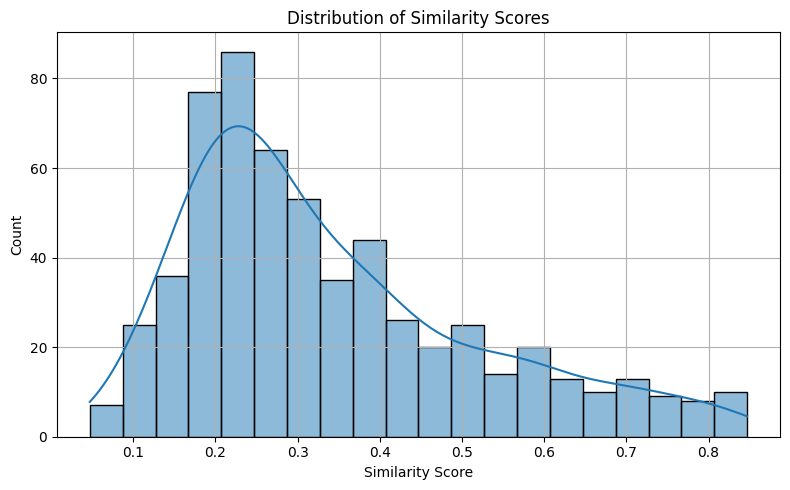

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df_sorted["Similarity Score"], bins=20, kde=True)
plt.title("Distribution of Similarity Scores")
plt.xlabel("Similarity Score")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


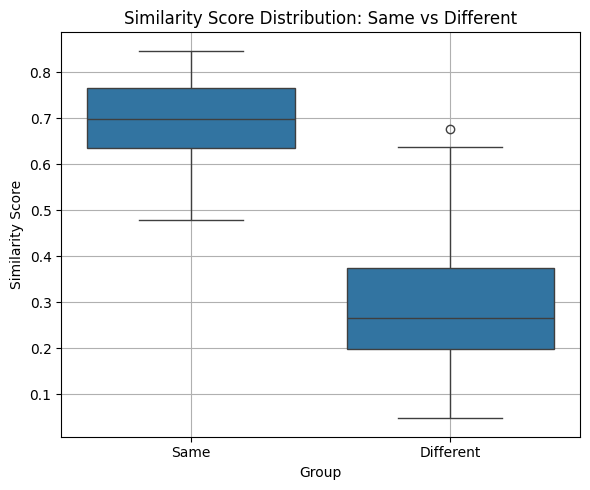

In [53]:
#Box plot same vs different
plt.figure(figsize=(6, 5))
sns.boxplot(x="Same/Different", y="Similarity Score", data=df_sorted)
plt.title("Similarity Score Distribution: Same vs Different")
plt.xlabel("Group")
plt.ylabel("Similarity Score")
plt.grid(True)
plt.tight_layout()
plt.show()


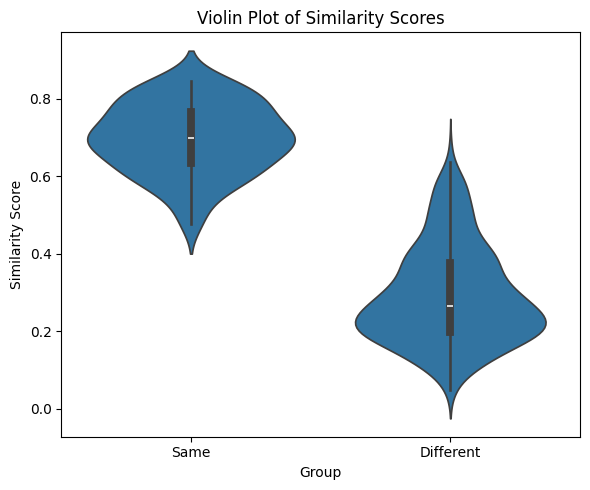

In [54]:
#Violin Plot
plt.figure(figsize=(6, 5))
sns.violinplot(x="Same/Different", y="Similarity Score", data=df_sorted)
plt.title("Violin Plot of Similarity Scores")
plt.xlabel("Group")
plt.ylabel("Similarity Score")
plt.tight_layout()
plt.show()


In [55]:
#Threshold based analysis
# Set your similarity threshold
threshold = 0.60

# Initialize counters
TP = FP = TN = FN = 0

for _, row in df_sorted.iterrows():
    actual = row["Same/Different"]
    score = row["Similarity Score"]

    if actual == "Same":
        if score >= threshold:
            TP += 1
        else:
            FN += 1
    else:  # actual == "Different"
        if score >= threshold:
            FP += 1
        else:
            TN += 1

# Compute precision, recall, F1 score, accuracy
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall    = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score  = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
accuracy  = (TP + TN) / (TP + TN + FP + FN)

# Print results
print("\n--- Threshold-Based Classification Report ---")
print(f"Threshold         : {threshold}")
print(f"True Positives    : {TP}")
print(f"False Positives   : {FP}")
print(f"True Negatives    : {TN}")
print(f"False Negatives   : {FN}")
print(f"Accuracy          : {accuracy:.2f}")
print(f"Precision         : {precision:.2f}")
print(f"Recall            : {recall:.2f}")
print(f"F1 Score          : {f1_score:.2f}")



--- Threshold-Based Classification Report ---
Threshold         : 0.6
True Positives    : 60
False Positives   : 7
True Negatives    : 518
False Negatives   : 10
Accuracy          : 0.97
Precision         : 0.90
Recall            : 0.86
F1 Score          : 0.88


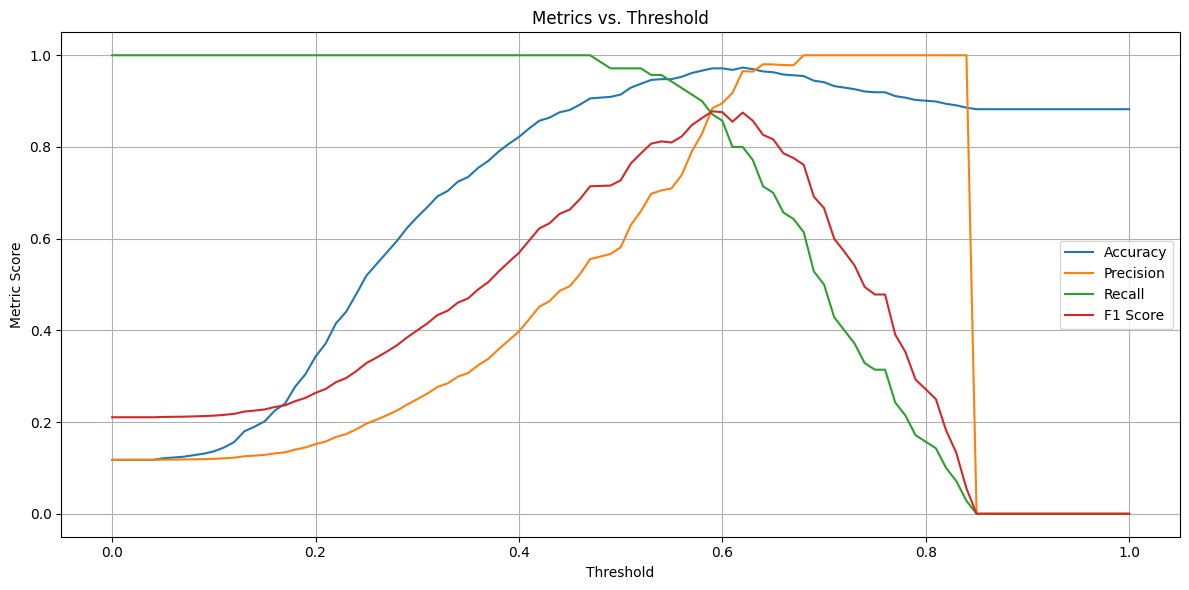

In [56]:
# 📈 1. Accuracy, Precision, Recall, F1 Score vs. Threshold
# This plot helps visualize how these metrics change across a range of thresholds, helping you pick the optimal one.

import numpy as np
import matplotlib.pyplot as plt

thresholds = np.arange(0.0, 1.01, 0.01)
accuracies, precisions, recalls, f1_scores = [], [], [], []

for threshold in thresholds:
    TP = FP = TN = FN = 0

    for _, row in df_sorted.iterrows():
        actual = row["Same/Different"]
        score = row["Similarity Score"]

        if actual == "Same":
            if score >= threshold:
                TP += 1
            else:
                FN += 1
        else:
            if score >= threshold:
                FP += 1
            else:
                TN += 1

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score  = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    accuracy  = (TP + TN) / (TP + TN + FP + FN)

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)
    accuracies.append(accuracy)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(thresholds, accuracies, label="Accuracy")
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1_scores, label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title("Metrics vs. Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


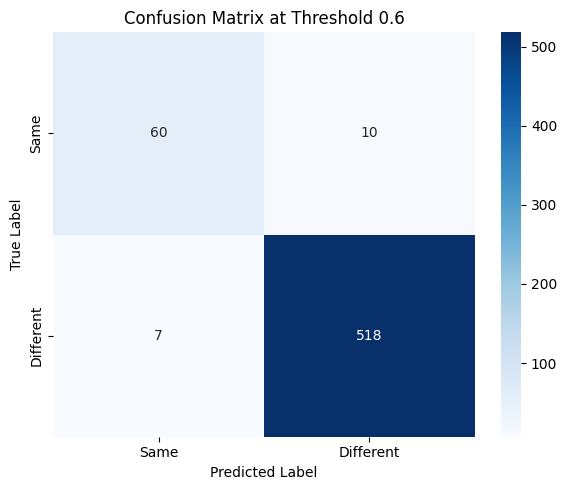

In [ ]:
# 📊 Confusion Matrix at Threshold 0.6

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Set your threshold
threshold = 0.6

# Initialize lists to store actual and predicted labels
actual_labels = []
predicted_labels = []

for _, row in df_sorted.iterrows():
    actual = row["Same/Different"]
    score = row["Similarity Score"]

    # Assign predicted label based on threshold
    predicted = "Same" if score >= threshold else "Different"
    
    actual_labels.append(actual)
    predicted_labels.append(predicted)

# Compute confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels, labels=["Same", "Different"])

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Same", "Different"], yticklabels=["Same", "Different"])
plt.title(f"Confusion Matrix at Threshold {threshold}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


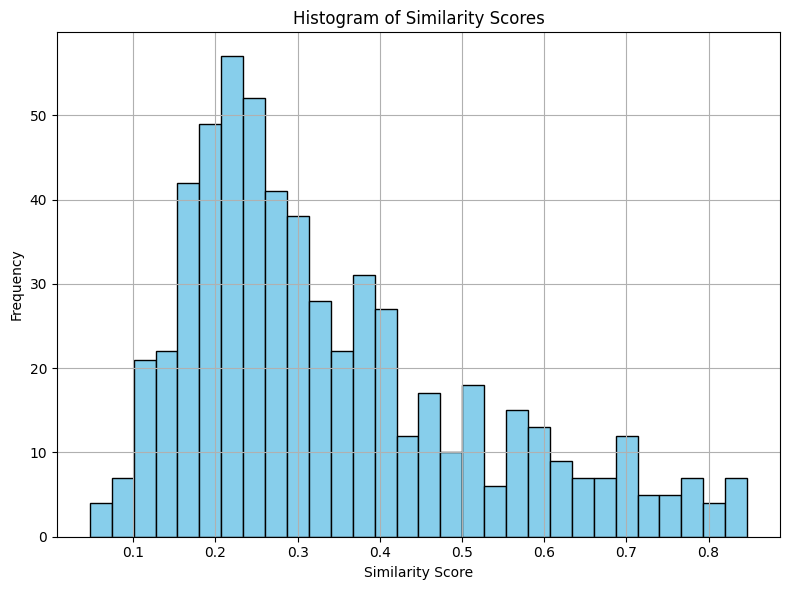

In [58]:
plt.figure(figsize=(8, 6))
plt.hist(df_sorted["Similarity Score"], bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram of Similarity Scores")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


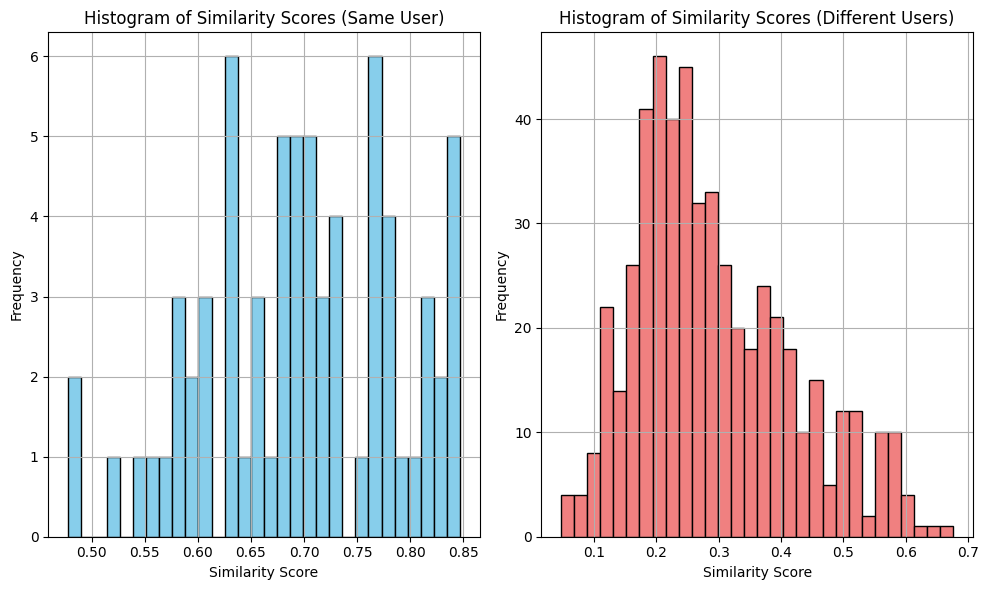

Statistics for Same User Comparisons:
count    70.000000
mean      0.696931
std       0.090415
min       0.477565
25%       0.634225
50%       0.698136
75%       0.766762
max       0.846902
Name: Similarity Score, dtype: float64

Statistics for Different User Comparisons:
count    525.000000
mean       0.292548
std        0.126225
min        0.047070
25%        0.198514
50%        0.265693
75%        0.375139
max        0.675971
Name: Similarity Score, dtype: float64


In [59]:
# Step 1: Plot histograms for "Same" and "Different" user comparisons

import matplotlib.pyplot as plt

# Step 2: Plotting the histograms for "Same" and "Different" comparisons
# Separate the DataFrame into 'Same' and 'Different' categories
same_df = df_sorted[df_sorted["Same/Different"] == "Same"]
different_df = df_sorted[df_sorted["Same/Different"] == "Different"]

# Plotting the histograms
plt.figure(figsize=(10, 6))

# Same User Comparison Histogram
plt.subplot(1, 2, 1)
plt.hist(same_df["Similarity Score"], bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram of Similarity Scores (Same User)")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.grid(True)

# Different User Comparison Histogram
plt.subplot(1, 2, 2)
plt.hist(different_df["Similarity Score"], bins=30, color='lightcoral', edgecolor='black')
plt.title("Histogram of Similarity Scores (Different Users)")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.grid(True)

plt.tight_layout()
plt.show()

# Step 3: Optional - Calculate statistics for both groups
same_stats = same_df["Similarity Score"].describe()
different_stats = different_df["Similarity Score"].describe()

print("Statistics for Same User Comparisons:")
print(same_stats)

print("\nStatistics for Different User Comparisons:")
print(different_stats)


C:\Users\ITinframanage\AppData\Local\Temp\ipykernel_15600\226493119.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Same/Different", y="Similarity Score", data=df_sorted, palette="Set2")


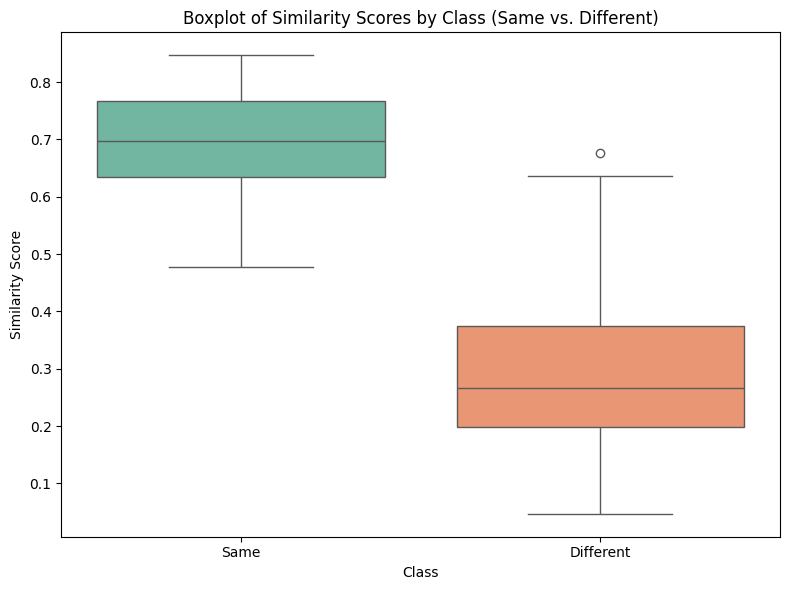

In [61]:
# 2. Boxplot of Similarity Scores by Class (Same vs. Different)
plt.figure(figsize=(8, 6))
sns.boxplot(x="Same/Different", y="Similarity Score", data=df_sorted, palette="Set2")
plt.title("Boxplot of Similarity Scores by Class (Same vs. Different)")
plt.xlabel("Class")
plt.ylabel("Similarity Score")
plt.tight_layout()
plt.show()


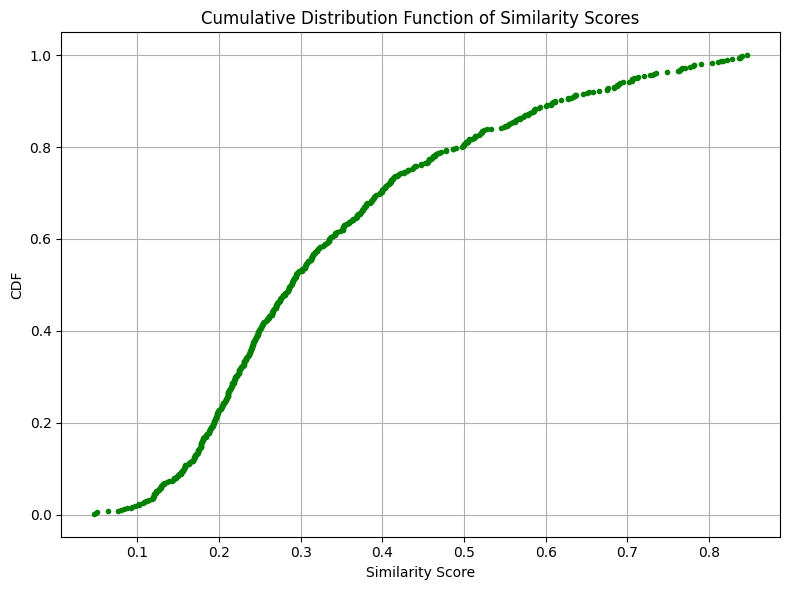

In [62]:
# 3. Cumulative Distribution Function (CDF)
# Sort similarity scores
sorted_scores = np.sort(df_sorted["Similarity Score"])

# Compute CDF
cdf = np.arange(1, len(sorted_scores) + 1) / len(sorted_scores)

plt.figure(figsize=(8, 6))
plt.plot(sorted_scores, cdf, marker='.', linestyle='none', color='green')
plt.title("Cumulative Distribution Function of Similarity Scores")
plt.xlabel("Similarity Score")
plt.ylabel("CDF")
plt.grid(True)
plt.tight_layout()
plt.show()


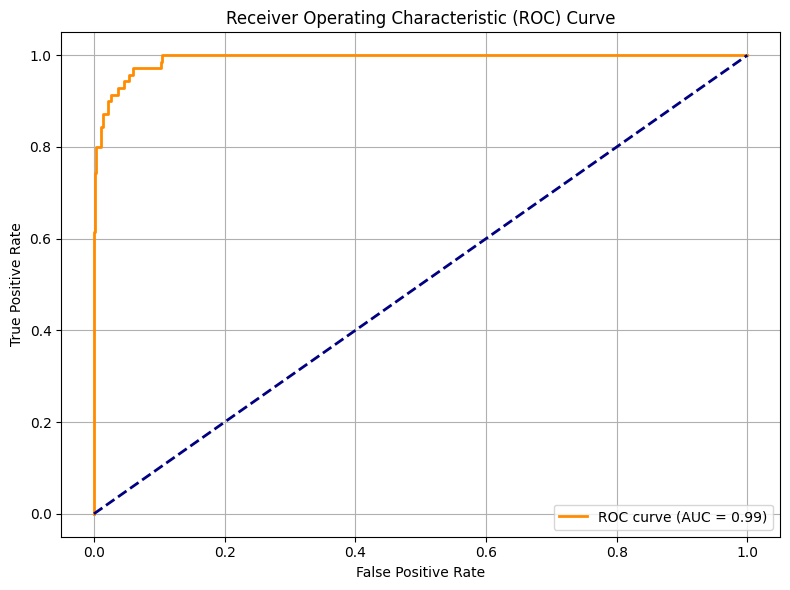

In [63]:
#4. ROC Curve (Receiver Operating Characteristic)

from sklearn.metrics import roc_curve, roc_auc_score

# Encode labels as 0 for "Different" and 1 for "Same"
df_sorted['Label'] = df_sorted['Same/Different'].apply(lambda x: 1 if x == 'Same' else 0)

# Get the true labels and predicted scores
y_true = df_sorted['Label']
y_scores = df_sorted['Similarity Score']

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc_score = roc_auc_score(y_true, y_scores)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


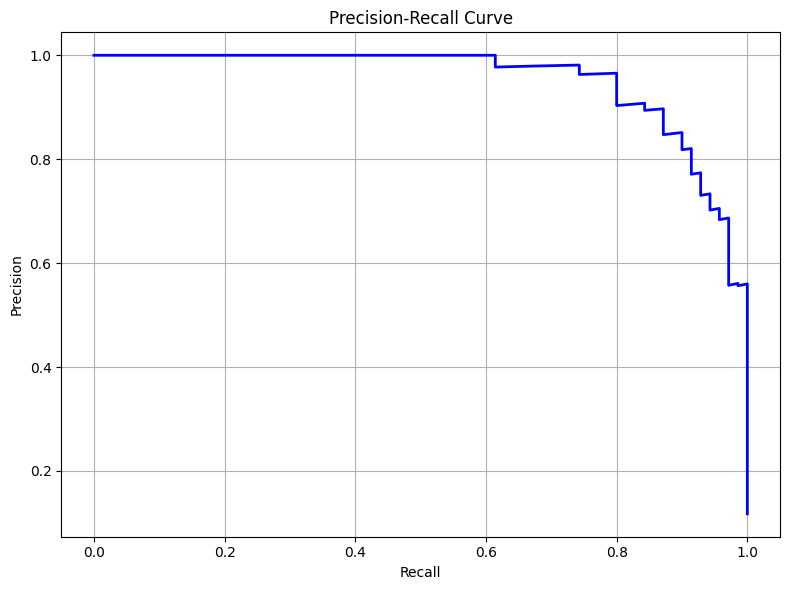

In [64]:
#5. Precision-Recall Curve
from sklearn.metrics import precision_recall_curve

# Compute precision and recall at various thresholds
precision, recall, _ = precision_recall_curve(y_true, y_scores)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.tight_layout()
plt.show()


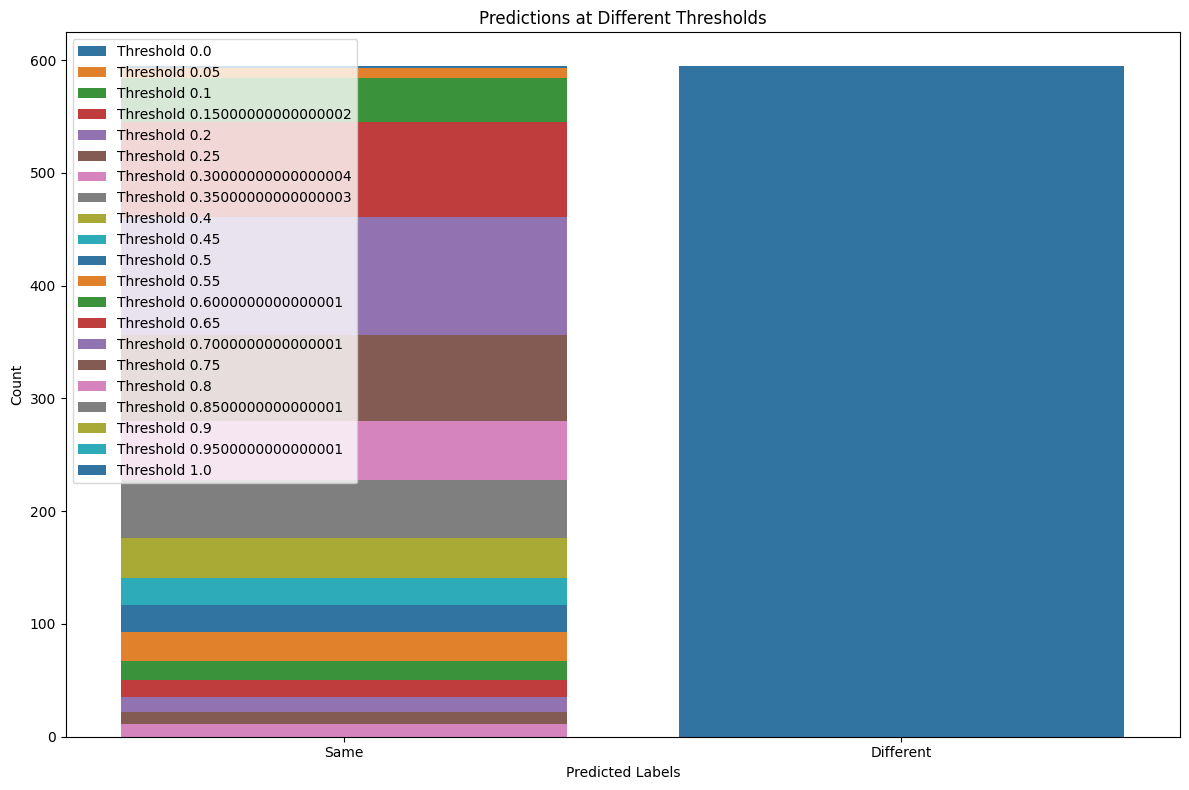

In [67]:
#6. Score distribution based on threshold
# Create new column for predicted labels at various thresholds
thresholds = np.arange(0.0, 1.01, 0.05)
predicted_labels_thresholds = {threshold: [] for threshold in thresholds}

for threshold in thresholds:
    df_sorted[f"Predicted at {threshold}"] = df_sorted['Similarity Score'].apply(lambda x: 'Same' if x >= threshold else 'Different')

# Plot how predicted labels change across thresholds
plt.figure(figsize=(12, 8))
for threshold in thresholds:
    sns.countplot(x=f"Predicted at {threshold}", data=df_sorted, label=f'Threshold {threshold}')
plt.title("Predictions at Different Thresholds")
plt.xlabel("Predicted Labels")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()
